In [9]:

from splat.read_colmap import read_images_text, qvec2rotmat
from splat.gaussians import Gaussians
from splat.gaussian_scene import GaussianScene
import pycolmap
import torch 
import torch.nn as nn
import numpy as np

from splat.utils import read_images_text, read_images_binary

colmap_path = "/Users/derek/Desktop/colmap/gerrard-hall/sparse/0"
reconstruction = pycolmap.Reconstruction(colmap_path)
test = False

points3d = reconstruction.points3D
images = read_images_binary("/Users/derek/Desktop/colmap/gerrard-hall/sparse/0/images.bin")
cameras = reconstruction.cameras

all_points3d = []
all_point_colors = []
image_num = 100

for idx, point in enumerate(points3d.values()):
    # I would assume this is seeing it from multiple images
    if point.track.length() >= 5:
        all_points3d.append(point.xyz)
        all_point_colors.append(point.color)
        
image = images[image_num]
print(image.name)
points_in_3d = []
points2d = []
colors2d = []
for idx, point in enumerate(image.xys):
    point3d_id = image.point3D_ids[idx]
    if point3d_id > 0:
        try:
            color = points3d[point3d_id].color
            points_in_3d.append(points3d[point3d_id].xyz)
            points2d.append(point)
            colors2d.append(color)
        except:
            pass
        
all_points3d = np.array(all_points3d)
all_point_colors = np.array(all_point_colors)
points_in_3d = np.array(points_in_3d)
points2d = np.array(points2d)
colors2d = np.array(colors2d)
gaussians = Gaussians(
    torch.Tensor(points_in_3d), 
    torch.Tensor(colors2d),
    model_path="./point_clouds"
)

IMG_2348.JPG
initialized_points


# Now print out what it should look like

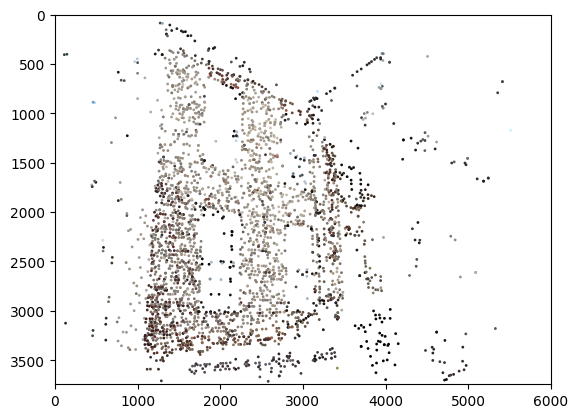

In [10]:
import matplotlib.pyplot as plt

plt.scatter(points2d[:, 0], points2d[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

In [11]:
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)

# The perspective projection implementation

torch.Size([3250, 3])


tensor(3767.3242)

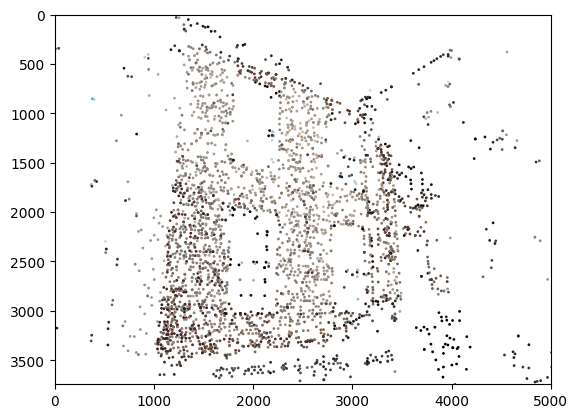

In [12]:
from splat.utils import ndc2Pix

from matplotlib import pyplot as plt

def clip(points: torch.Tensor, w: torch.Tensor) -> torch.Tensor:
    truth = (points[:, 0] > -w) & (points[:, 0] < w) & (points[:, 1] > -w) & (points[:, 1] < w)
    truth = truth & (points[:, 2] > -w) & (points[:, 2] < w)
    truth = truth & (points[:, 3] >= 0)
    print(truth.shape)
    return points[truth], truth

def in_view_frustum(
    points: torch.Tensor, minimum_z: float, view_matrix: torch.Tensor
) -> torch.Tensor:
    """
    Given a view matrix (transforming from world to camera coords) and a minimum
    z value, return a boolean tensor indicating whether the points aree in view.

    points is a Nx3 tensor and we return a N tensor indicating whether the point 
    is in view.
    """
    projected_points = points @ view_matrix
    z_component = projected_points[:, 2]
    truth = z_component > minimum_z
    truth = truth & (projected_points[:, 0] > -1.3) & (projected_points[:, 0] < 1.3)
    truth = truth & (projected_points[:, 1] > -1.3) & (projected_points[:, 1] < 1.3)
    return truth


points = torch.Tensor(points_in_3d)
in_view = in_view_frustum(points, .00001, scene.images[image_num].world2view[:3, :3])
in_view = torch.ones(points.shape[0]).bool()
points = points[in_view]
colors = colors2d[in_view]

homogeneous_points = torch.cat([points, torch.ones(points.shape[0], 1)], dim=1)
points2 = (homogeneous_points @ scene.images[image_num].world2view)
points2 = points2 @ scene.images[image_num].projection_matrix
# points2, truth = clip(points2, points2[:, 3])
truth = torch.ones(points2.shape[0]).bool()
points2 = points2[:, :3] / points2[:, 3].unsqueeze(1)


colors = colors[truth]
final_points = points2
print(final_points.shape)
final_points[:, 0] = ndc2Pix(final_points[:, 0], scene.images[image_num].width)
final_points[:, 1] = ndc2Pix(final_points[:, 1], scene.images[image_num].height)
plt.scatter(final_points[:, 0], final_points[:, 1], c=colors / 256,s=1)
plt.xlim(0, 5000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 
points2[:, 1].max()

# Using intrinisc and extrinsic matrices

torch.Size([3250, 4]) torch.Size([3250, 2]) (3250, 3)


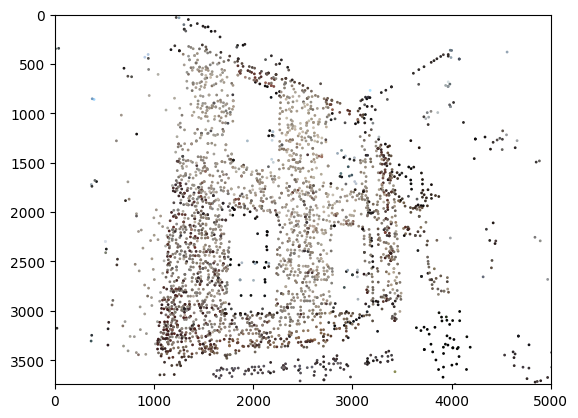

In [13]:
points = torch.Tensor(points_in_3d)
homogeneous_points = torch.cat([points, torch.ones(points.shape[0], 1)], dim=1)
points1 = (scene.images[image_num].extrinsic_matrix @ homogeneous_points.T).T
points1 = (scene.images[image_num].intrinsic_matrix @ points1.T).T
points1 = points1[:, :2] / points1[:, 2].unsqueeze(1)
print(homogeneous_points.shape, points1.shape, colors2d.shape)
plt.scatter(points1[:, 0], points1[:, 1], c=colors2d / 256, s=1)
plt.xlim(0, 5000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

In [5]:
scene = GaussianScene(
    colmap_path=colmap_path,
    gaussians=gaussians,
)
image_num = 14
with torch.no_grad():
    points1, colors = scene.render_points_image(image_num)
    points2, colors = scene.render_points_image2(image_num)
    points1 = points1[:, :2] / points1[:, 2][:, None]
    # points2 = points2[:, :2] / points2[:, 2][:, None]

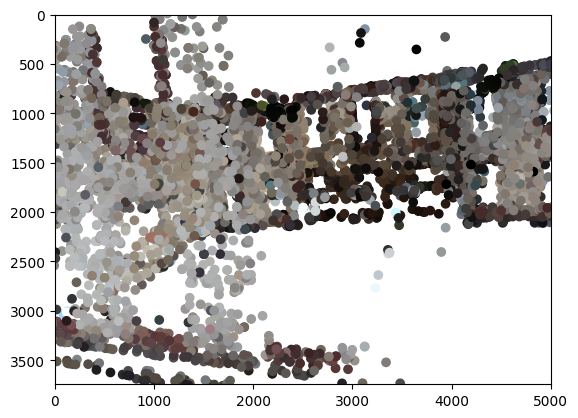

In [6]:
from matplotlib import pyplot as plt

plt.scatter(points2[:, 0], points2[:, 1], c=colors.detach())
plt.xlim(0, 5000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis() 

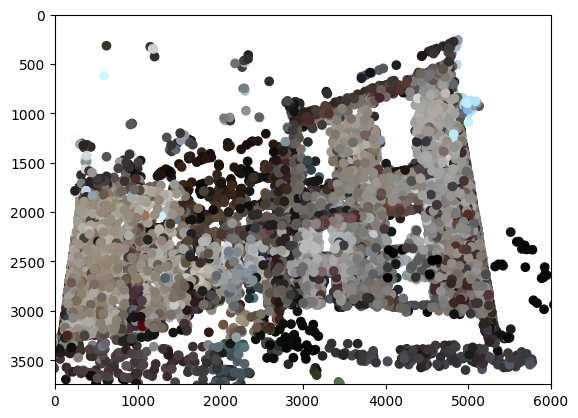

In [7]:
plt.scatter(points1[:, 0], points1[:, 1], c=colors.detach())
plt.xlim(0, 6000)
plt.ylim(0, 3744)
plt.gca().invert_yaxis()

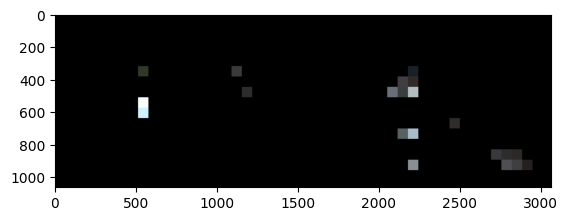

In [5]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))

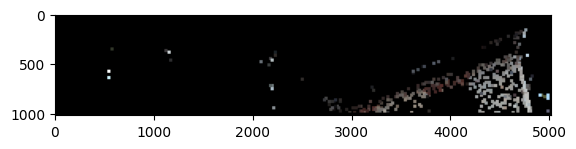

In [4]:
from matplotlib import pyplot as plt

plt.imshow(output_scene.detach().numpy().transpose(1, 0, 2))